<h1 align="center"> Paris : a world cuisine capital ? </h1>

<h3 align="center">    Coursera Applied Data Science Capstone Project by IBM </h3>

<h2>Table of contents</h2>

<div>
    <ol>
        <li><a href="#ref1">Introduction</a></li>
        <li><a href="#ref2">Data Presentation</a></li>
        <li><a href="#ref3">Data Wrangling</a>
            <ul>
                <li><a href="#ref31">Building the Parisian Neighborhoods</a></li>
                <li><a href="#ref32">Preparing the Foursquare API</a></li>
                <li><a href="#ref33">Refining the data</a></li>
                <li><a href="#ref34">One-Hot Encoding</a></li>
                <li><a href="#ref35">Overview of the data</a></li>
            </ul>
        </li>
        <li><a href="#ref4">Clustering the neighborhood</a>
            <ul>
                <li><a href="#ref41">Finding the optimum number of clusters</a></li>
                <li><a href="#ref42">k-means algorithm</a></li>
                <li><a href="#ref43">Display the results on a map</a></li>
                <li><a href="#ref44">Examine the proposed clusters</a></li>
            </ul>
        </li>
        <li><a href="#ref5">Conclusion</a></li>
     </ol>
</div>

----

<a id="ref1"></a>
## 1. Introduction

### Background
Paris, capital of France, is a model for its culture and life habits. With all its museums and architecture landmarks, the city of Light offers plenty of strolls for everyone and everything, including the inescapable French specialty : the cuisine.  
In fact, Paris is acclaimed for its restaurants and its gourmet cuisine, but also for its bistros and bakeries, scattering all around the city.  
However, with today's influence of Paris metropolitan area (_Grand Paris_), counting more than seven millions inhabitants (INSEE, 2016, <a href='https://www.insee.fr/fr/statistiques/1405599?geo=EPCI-200054781'>link</a> in French), and receiving millions of tourists each year, Paris basically owns every national cuisine in the world.  
With such cosmopolitan area, does one small village of indomitable French dishes still holds out against the invaders tastes ?


### Problem

The idea of this project is to segment the Parisian neighborhoods into major clusters depending on the origin of their cuisine.  
This origin will be determined by the surrounding restaurants, thanks to an unsupervised machine learning algorithm, namely 'k-mean clustering', and leveraging the Foursquare location data.


### Stakeholders

The results of this analysis can benefit several actors :
 * City mappers and institutions : based on the proposed clusters, these actors would be able to visualize if minorities are concentrating their activities in specific neighborhoods thus proposing them adequate accommodations ;
 * Restaurant owners : knowing the main cuisine of each Parisian neighborhood, someone who wants to open a restaurant in Paris could determine in which area this restaurant could profit ;
 * Tourists and residents : thanks to this clustering, choosing a place to eat will become easier as long as you know what kind of food you want, then just wander around the beautiful streets of a specialized area and pick the restaurant you're interested in !

<a id="ref2"></a>
## 2. Data Presentation

To answer our problem, we will use the following data :

### Paris Data

Link : https://opendata.paris.fr/explore/dataset/quartier_paris/information/  
Licence : <a href=http://opendatacommons.org/licenses/odbl/ >Open Database License (ODbL)</a>

This official dataset provides all the administrative districts of Paris with their surfaces, their localizations and their shapes. 
These administrative districts consists in a subdivision of the main boroughs (_"Arrondissements"_) into four parts. Therefore this dataset proposes 80 neighborhoods. 
In this project we download a CSV file and a GeoJSON file from this source.

### Foursquare Places API

Link : https://developer.foursquare.com/docs

Foursquare API is a location data provider based on REST API. Given a specific localization, Foursquare API will retrieve all the nearby venues with their categories, such as restaurant or museums.  
The most interesting benefits of this API is the hierarchy in their categories : as we will focus on restaurant, Foursquare already know the subdivision of this broad category. A list of this hierarchy can be found <a href=https://developer.foursquare.com/docs/resources/categories>here</a>.  

For each query, Foursquare API returns a JSON file containing a lot of informations, such as name of the venue, its category, its localization and so on.

<a id="ref3"></a>
## 3. Data Wrangling

Before beginning, we need to import all the required libraries :

In [1]:
import numpy as np
import pandas as pd
import requests

# Package to render map
import folium

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

<a id="ref31"></a>
### 3.1 Building the Parisian Neighborhoods

After importing the file `quartier_paris.csv` to our workplace from the ParisData website, we can load it into a dataframe :

In [2]:
df_parisdata = pd.read_csv("quartier_paris.csv", ';')
df_parisdata.head()

,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry
0,750000023,23,7510603,Notre-Dame-des-Champs,6,750000006,4559.989773,8.613070e+05,"48.846427594,2.32735687823","{""type"": ""Polygon"", ""coordinates"": [[[2.336756..."
1,750000055,55,7511403,Petit-Montrouge,14,750000014,5490.636672,1.345774e+06,"48.8266526255,2.32643699922","{""type"": ""Polygon"", ""coordinates"": [[[2.329136..."
2,750000074,74,7511902,Pont-de-Flandre,19,750000019,6397.871676,2.376238e+06,"48.8955557746,2.38477722927","{""type"": ""Polygon"", ""coordinates"": [[[2.384878..."
3,750000062,62,7511602,Muette,16,750000016,11962.438594,5.477898e+06,"48.8632745438,2.2599358317","{""type"": ""Polygon"", ""coordinates"": [[[2.245624..."
4,750000064,64,7511604,Chaillot,16,750000016,5207.046446,1.424035e+06,"48.8684336145,2.29167904274","{""type"": ""Polygon"", ""coordinates"": [[[2.292681..."


This `df_parisdata` possesses several irrelevant columns, such as `PERIMETRE` or `SURFACE`, and others are redundant like `N_SQ_QU` and `C_QU` representing an ID for each neighborhood.  
In addition, some columns are interesting but need to be rearranged to become useful:
 * `Geometry X Y` is a string, but the Foursquare API need two float as variables, one for latitude and one for longitude. We need to split this column into two others;
 * `Geometry`: providing the shape of a neighborhood, these data are really useful. However with the Foursquare API, we can not use such detailed information.  
 
Moreover, some rewording is necessary to quickly understand the information inside each column.

In [3]:
# Drop irrelevants features
df_neigh = df_parisdata.drop(['N_SQ_QU', 'C_QUINSEE','N_SQ_AR', 'PERIMETRE', 'SURFACE'], axis=1)

#Split the Geometry_X_Y into Latitude and Longitude
df_neigh[['Latitude','Longitude']] = df_neigh['Geometry X Y'].str.split(',', expand=True).astype(float)
df_neigh.drop(['Geometry X Y'], axis=1, inplace=True)

# Rename the columns for easier understanding in english
df_neigh.rename(columns={'C_QU':'ID','L_QU':'Neighborhood','C_AR':'Borough'}, inplace=True)

Now concerning the `Geometry`parameter, we need to understand how Foursquare API works to benefit these informations.  
To remind, given a localization (with latitude and longitude), Foursquare API return a list of the nearest point of interest.  
Here is the specificity : the nearest point can be obtain following two methods :
 * circle : inside a circle with a defined radius with the localization defined as center ;
 * square : inside a square starting from a South-West point to a North-East one.
 
If the circle methods is interesting when trying to localize a user in a city and to propose this user a relevant and close place to visit, our case would prefer the square method as we'd like to cluster areas with different shapes. Like that, queries to  retrieve venues would rely on a full surface and not only in the surrounding of a unique data point.  
However the square method owns a drawback : we can only draw a non-rotating square, yet Parisian neighborhoods present really diverse and complex shapes, none of them with the same surface.  
To tackle this issue, we make the choice to select for each neighborhood a square surface starting from the furthest point in the South-West to the furthest one in North-East. 
These extreme points correspond to the minimum and maximum of latitude and longitude, accessible by the `Geometry` column thanks to the following rearrangements :

In [4]:
min_long = []
max_long = []
min_lat = []
max_lat = []

# Delete the non coordinates related informations (like "type, Polygon...") 
count = 0
stop_caracter = ''
while stop_caracter != '[':
    stop_caracter = df_neigh.iloc[0,3][count] #Use the first line as reference as each line are similar
    count += 1
count += 1   #Add +1 in order to also delete the second '[' as a third one exist

for i in df_neigh.index:
    long = []
    lat = []
    coordinates = []
    df_neigh.iloc[i,3] = df_neigh.iloc[i,3][count:len(df_neigh.iloc[i,3])-3]  #Delete also the 3 last caracters which are ']]}'
    coordinates = df_neigh.iloc[i,3].split(',')
    for j in range(len(coordinates)):
        if coordinates[j][-1] == ']':
            lat.append(float(coordinates[j][1:len(coordinates[j])-1]))
        elif coordinates[j][0] == '[':
            long.append(float(coordinates[j][1:]))
        else :
            long.append(float(coordinates[j][2:]))
    
    min_long.append(min(long))
    max_long.append(max(long))
    min_lat.append(min(lat))
    max_lat.append(max(lat))

# Add new columns for each variable
df_neigh['Min_Longitude'] = min_long
df_neigh['Max_Longitude'] = max_long
df_neigh['Min_Latitude'] = min_lat
df_neigh['Max_Latitude'] = max_lat

# Drop the useless column
df_neigh.drop(['Geometry'], axis=1, inplace=True)

With these rearrangements, we finally have our Parisian neighborhoods dataframe ready to go !

In [5]:
df_neigh.head()

,ID,Neighborhood,Borough,Latitude,Longitude,Min_Longitude,Max_Longitude,Min_Latitude,Max_Latitude
0,23,Notre-Dame-des-Champs,6,48.846428,2.327357,2.316572,2.336789,48.839653,48.852477
1,55,Petit-Montrouge,14,48.826653,2.326437,2.314158,2.336089,48.818896,48.834976
2,74,Pont-de-Flandre,19,48.895556,2.384777,2.370165,2.398817,48.886618,48.902162
3,62,Muette,16,48.863275,2.259936,2.229585,2.291954,48.850356,48.876355
4,64,Chaillot,16,48.868434,2.291679,2.283351,2.301590,48.859909,48.877491


To visualize these neighborhoods, we can use the Folium package.  
On this map we can add a Choropleth layer to represent the official neighborhoods shapes. This layer is obtained from a GeoJSON file, imported from Paris Data website.

In [6]:
import json

# Create a folium map
paris_map = folium.Map(location=[48.866667, 2.333333], zoom_start=12)

# Load the geojson file to add the official neighborhood shapes
with open('quartier_paris.geojson') as json_file:
    geo_paris = json.load(json_file)

# Render the neighborhoods shapes
paris_map.choropleth(
    geo_data = geo_paris,
    fill_color='Blue', 
    fill_opacity=0.35, 
    line_opacity=0.8,
    line_color='white'
)

# Add a marker for each neighborhood to display their names
for lat, lon, neigh, borough in zip(df_neigh['Latitude'], df_neigh['Longitude'], df_neigh['Neighborhood'],df_neigh['Borough']):
    label = '{}, Borough: {}'.format(neigh, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=' #f4d03f',
        fill=True,
        fill_color=' #f4d03f',
        fill_opacity=0.7,
        parse_html=False).add_to(paris_map)

# Display the map
paris_map

<a id="ref32"></a>
### 3.2 Preparing the Foursquare API

Before querying the Foursquare API, we need to prepare it by defining the required credentials, defining the number of venues to retrieve (`LIMIT`) and create some functions to obtain relevant data.  

In this project, we set the limit to 100 venues per neighborhood, and impose the Foursquare API to retrieve the "Restaurant" category only.

In [7]:
# Credential for Foursquare API
CLIENT_ID = 'CLIENT_ID'
CLIENT_SECRET = 'CLIENT_SECRET'
VERSION = '20191220' # Foursquare API version

# Maximum number of venues to retrieve par call
LIMIT = 100

# Define the requested category, in our project restaurants
cat_ID = '4d4b7105d754a06374d81259'

As the API request returns a JSON file, we define a function to extract the category of the venue :

In [8]:
# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Then we define another function to build a new dataframe containing all the required data for our study : Name of the neighborhood, name of the venues, their localization and their categories. 

In [9]:
def getNearbyVenues(names, min_latitudes, max_latitudes, min_longitudes, max_longitudes):
    
    venues_list=[]
    for name, min_lat, max_lat, min_lng, max_lng in zip(names, min_latitudes, max_latitudes, min_longitudes, max_longitudes):
        # Uncomment if need to follow the process
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&intent=browse&sw={},{}&ne={},{}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            min_lat, 
            min_lng, 
            max_lat, 
            max_lng,
            LIMIT,
            cat_ID)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,  
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Finally we just need to call the previous function to create the `paris_venues`, associating neighborhoods and their restaurants :

In [92]:
paris_venues = getNearbyVenues(names=df_neigh['Neighborhood'], 
                               min_latitudes=df_neigh['Min_Latitude'], 
                               max_latitudes=df_neigh['Max_Latitude'], 
                               min_longitudes=df_neigh['Min_Longitude'], 
                               max_longitudes=df_neigh['Max_Longitude']
                              )

Notre-Dame-des-Champs
Petit-Montrouge
Pont-de-Flandre
Muette
Chaillot
Epinettes
Invalides
Faubourg-Montmartre
Gaillon
Amérique
Ecole-Militaire
Grenelle
Auteuil
Saint-Victor
Madeleine
Saint-Fargeau
Porte-Dauphine
Grandes-Carrières
Saint-Merri
Notre-Dame
Gros-Caillou
Arsenal
Jardin-des-Plantes
Porte-Saint-Martin
Roquette
Picpus
Plaisance
Folie-Méricourt
Salpêtrière
Place-Vendôme
Combat
Charonne
Javel
Rochechouart
Bercy
Halles
Monnaie
Odéon
Champs-Elysées
Maison-Blanche
Croulebarbe
Vivienne
Enfants-Rouges
Saint-Germain-des-Prés
Saint-Vincent-de-Paul
Saint-Ambroise
Bel-Air
Montparnasse
Plaine de Monceaux
Val-de-Grâce
Necker
Père-Lachaise
La Chapelle
Saint-Gervais
Saint-Thomas-d'Aquin
Porte-Saint-Denis
Saint-Germain-l'Auxerrois
Villette
Quinze-Vingts
Arts-et-Métiers
Archives
Faubourg-du-Roule
Europe
Sainte-Marguerite
Parc-de-Montsouris
Saint-Lambert
Sainte-Avoie
Hôpital-Saint-Louis
Belleville
Ternes
Batignolles
Mail
Bonne-Nouvelle
Gare
Clignancourt
Goutte-d'Or
Sorbonne
Saint-Georges
Chaussé

<a id="ref33"></a>
### 3.3 Refining the data

In [7]:
# Used during the process to avoid calling the Foursquare API everytime
paris_venues = pd.read_csv('paris_venues.csv')
paris_venues.drop(['Unnamed: 0'], axis=1, inplace=True)

At this point, we now possess a dataframe with all the Parisian neighborhoods and their restaurants (up to 100).  
These data look like following :

In [8]:
print('Total number of restaurant :',paris_venues.shape[0])
paris_venues.head(10)

Total number of restaurant : 6991


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Notre-Dame-des-Champs,L'Avant-Comptoir du Marché,48.851781,2.335429,Bistro
1,Notre-Dame-des-Champs,Le Bistrot des Campagnes,48.840981,2.330782,French Restaurant
2,Notre-Dame-des-Champs,L'Épi Dupin,48.849660,2.325133,French Restaurant
3,Notre-Dame-des-Champs,Le Petit Sommelier,48.840167,2.321475,French Restaurant
4,Notre-Dame-des-Champs,Marcello,48.852340,2.335242,Italian Restaurant
5,Notre-Dame-des-Champs,La Crêperie de Josselin,48.841704,2.325411,Creperie
6,Notre-Dame-des-Champs,Mamie Gâteaux,48.848513,2.324560,French Restaurant
7,Notre-Dame-des-Champs,Chez Fernand,48.851908,2.334450,French Restaurant
8,Notre-Dame-des-Champs,Le Petit Lutetia,48.848348,2.320596,French Restaurant
9,Notre-Dame-des-Champs,La Closerie des Lilas,48.839973,2.335926,French Restaurant


Inside all these 6991 restaurants, we first check how many different categories we have :

In [9]:
print('Number of different restaurant categories :',len(paris_venues['Venue Category'].unique()))

Number of different restaurant categories : 123


With these 123 different categories, we can wonder if some of them are not redundant or irrelevant.  
As an example, we spot the category `Restaurant` which sounds too broad to be relevant as we have no clue about the cuisine served in such establishment.

In [10]:
print('Number of Venues which category are Restaurant :', paris_venues[paris_venues['Venue Category']=='Restaurant'].shape[0])
paris_venues[paris_venues['Venue Category']=='Restaurant'].head()

Number of Venues which category are Restaurant : 226


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
26,Notre-Dame-des-Champs,sathees,48.851748,2.336009,Restaurant
60,Notre-Dame-des-Champs,La Table d'Aki,48.850951,2.319239,Restaurant
152,Petit-Montrouge,Café Chin-Chin,48.824101,2.335929,Restaurant
161,Petit-Montrouge,L'Île au Blé Noir,48.833593,2.317457,Restaurant
163,Petit-Montrouge,Auto Passion Café,48.823612,2.324756,Restaurant


Like the previous example, we can find several other too general category. In this project we propose to drop each venue with the following category :

In [11]:
# Creating a list of the category to drop
list_to_drop = ['Breakfast Spot', 'BBQ Joint', 'Bagel Shop', 'Café','Cafeteria', 'Comfort Food Restaurant', 'Diner',
                'Food', 'Food Court', 'Food Truck', 'Fried Chicken Joint', 'Gluten-free Restaurant',
                'Pet Café', 'Restaurant', 'Salad Place', 'Sandwich Place', 'Seafood Restaurant', 'Snack Place',
                'Soup Place', 'Theme Restaurant', 'Vegetarian / Vegan Restaurant', 'Wings Joint']

Another interesting information concerns the frequency for each category.

In [12]:
paris_venues.groupby(['Venue Category']).count().sort_values('Venue', ascending=False).Venue

Venue Category
French Restaurant       1831
Italian Restaurant       558
Bakery                   388
Café                     380
Japanese Restaurant      363
                        ... 
English Restaurant         1
Fondue Restaurant          1
Provençal Restaurant       1
German Restaurant          1
Cuban Restaurant           1
Name: Venue, Length: 123, dtype: int64

The last list proves the numerous amount of French restaurants all around Paris, representing around 26% of the total number of restaurants.

In [13]:
print('Number of Venue which category is French Restaurant :', paris_venues[paris_venues['Venue Category']=='French Restaurant'].shape[0])
paris_venues[paris_venues['Venue Category']=='French Restaurant'].head()

Number of Venue which category is French Restaurant : 1831


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Notre-Dame-des-Champs,Le Bistrot des Campagnes,48.840981,2.330782,French Restaurant
2,Notre-Dame-des-Champs,L'Épi Dupin,48.849660,2.325133,French Restaurant
3,Notre-Dame-des-Champs,Le Petit Sommelier,48.840167,2.321475,French Restaurant
6,Notre-Dame-des-Champs,Mamie Gâteaux,48.848513,2.324560,French Restaurant
7,Notre-Dame-des-Champs,Chez Fernand,48.851908,2.334450,French Restaurant


Like the ones in the `list_to_drop`list, the French Restaurant category is actually too global to be used. In fact some venues' name could be assigned to a more precise category, such as Café or Bistro.  
In this project, we make the choice to simply delete this category, but to keep more regional ones.  
But we can already answer our first questions : French cuisine is everywhere in Paris !

In [14]:
list_to_drop.append('French Restaurant')

While dropping the irrelevant categories, we also propose to rename some of them when they are too precise. For example, the Chinese cuisine is divided into several region, such as Cantonese, Jiangxi, Shadong... We prefer to organize all of them under the same name, namely Chinese Restaurant.

In [15]:
paris_venues_rearranged = pd.DataFrame(paris_venues)

paris_venues_rearranged['Venue Category'].replace('Bistro', 'Brasserie', inplace=True)
paris_venues_rearranged['Venue Category'].replace(['Cantonese Restaurant', 'Dim Sum Restaurant', 'Jiangxi Restaurant', 'Noodle House', 'Shandong Restaurant',
    'Shanxi Restaurant', 'Szechuan Restaurant'], 'Chinese Restaurant', inplace=True)
paris_venues_rearranged['Venue Category'].replace(['Deli / Bodega', 'Empanada Restaurant'], 'Spanish Restaurant', inplace=True)
paris_venues_rearranged['Venue Category'].replace('Fish & Chips Shop', 'English Restaurant', inplace=True)
paris_venues_rearranged['Venue Category'].replace(['Okonomiyaki Restaurant', 'Ramen Restaurant', 'Soba Restaurant', 'Sushi Restaurant', 
                                                   'Udon Restaurant'], 'Japanese Restaurant', inplace=True)
paris_venues_rearranged['Venue Category'].replace('Poke Place', 'Hawaiian Restaurant', inplace=True)
paris_venues_rearranged['Venue Category'].replace('Souvlaki Shop', 'Greek Restaurant', inplace=True)
paris_venues_rearranged['Venue Category'].replace('Trattoria/Osteria', 'Italian Restaurant', inplace=True)

for item_to_drop in list_to_drop:
    paris_venues_rearranged.drop(paris_venues[paris_venues['Venue Category']==item_to_drop].index, inplace=True)

paris_venues_rearranged.reset_index(drop=True)

print('Total number of restaurant after rearrangement :',paris_venues_rearranged.shape[0])
paris_venues_rearranged.head()

Total number of restaurant after rearrangement : 4008


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Notre-Dame-des-Champs,L'Avant-Comptoir du Marché,48.851781,2.335429,Brasserie
4,Notre-Dame-des-Champs,Marcello,48.852340,2.335242,Italian Restaurant
5,Notre-Dame-des-Champs,La Crêperie de Josselin,48.841704,2.325411,Creperie
10,Notre-Dame-des-Champs,Poilâne,48.851292,2.329054,Bakery
12,Notre-Dame-des-Champs,Le Plomb du Cantal,48.840651,2.324396,Auvergne Restaurant


Like in the beginning, we check the frequency for each category :

In [16]:
print('Number of different restaurant categories after rearrangement:',len(paris_venues_rearranged['Venue Category'].unique()))
paris_venues_rearranged.groupby(['Venue Category']).count().sort_values('Venue', ascending=False).Venue

Number of different restaurant categories after rearrangement: 81


Venue Category
Italian Restaurant       562
Japanese Restaurant      475
Brasserie                391
Bakery                   388
Pizza Place              220
                        ... 
Cuban Restaurant           1
German Restaurant          1
Fondue Restaurant          1
Venezuelan Restaurant      1
Provençal Restaurant       1
Name: Venue, Length: 81, dtype: int64

To end on the data refining, we should check if deleting and regrouping all these categories doesn't restrict too much the remaining data.  
In addition, knowing which neighborhood possess less than 100 restaurants could be interesting to explain the final results.

In [17]:
print('Number of venues per Neighborhood BEFORE refining')
print(paris_venues.groupby(['Neighborhood']).count().sort_values('Venue', ascending=False).Venue)
print('\n', '-------------------------', '\n')
print('Number of venues per Neighborhood AFTER refining')
print(paris_venues_rearranged.groupby(['Neighborhood']).count().sort_values('Venue', ascending=False).Venue)

Number of venues per Neighborhood BEFORE refining
Neighborhood
Montparnasse       100
Saint-Georges      100
Saint-Lambert      100
Grenelle           100
Gros-Caillou       100
                  ... 
Ecole-Militaire     48
Sainte-Avoie        42
Quinze-Vingts       40
La Chapelle         39
Goutte-d'Or         24
Name: Venue, Length: 80, dtype: int64

 ------------------------- 

Number of venues per Neighborhood AFTER refining
Neighborhood
Gare                   82
Grenelle               70
Javel                  68
Bonne-Nouvelle         68
Hôpital-Saint-Louis    67
                       ..
Sainte-Avoie           22
La Chapelle            21
Ecole-Militaire        21
Quinze-Vingts          20
Goutte-d'Or            14
Name: Venue, Length: 80, dtype: int64


These series could be shown as histograms :

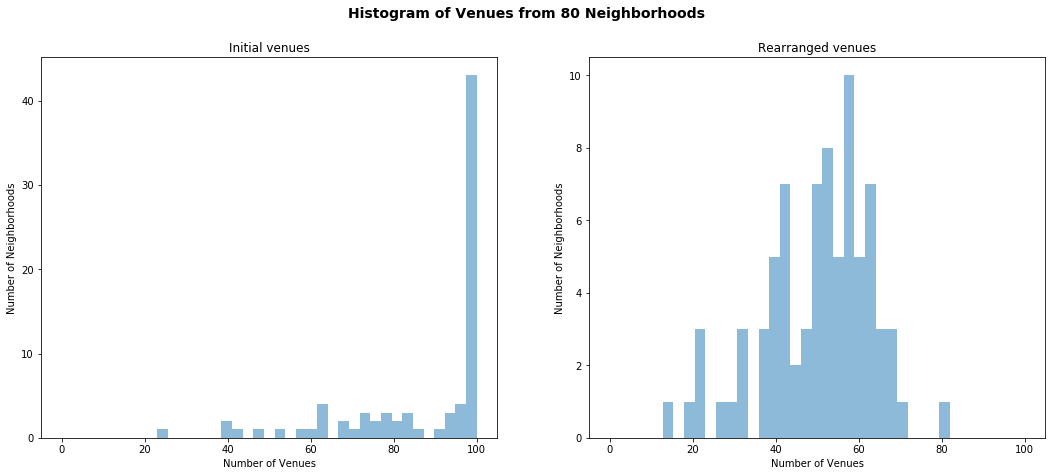

In [18]:
bins = np.linspace(0, 100, 40)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.hist(paris_venues.groupby(['Neighborhood']).count().Venue, bins, alpha=0.5, label='Initiale')
ax1.set_title("Initial venues")
ax1.set_xlabel('Number of Venues')
ax1.set_ylabel('Number of Neighborhoods')

ax2.hist(paris_venues_rearranged.groupby(['Neighborhood']).count().Venue, bins, alpha=0.5, label='Rearranged')
ax2.set_title("Rearranged venues")
ax2.set_xlabel('Number of Venues')
ax2.set_ylabel('Number of Neighborhoods')

plt.suptitle(('Histogram of Venues from 80 Neighborhoods'), fontsize=14, fontweight='bold')


plt.show()

Or even on a same figure to keep the same scale :

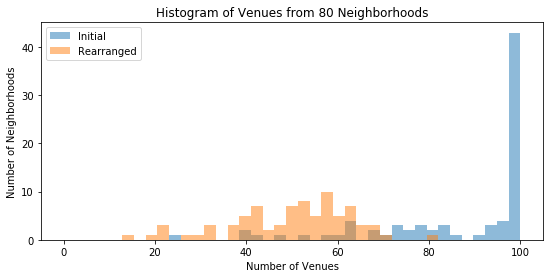

In [19]:
plt.figure(figsize=[9.0, 4.0])
plt.hist(paris_venues.groupby(['Neighborhood']).count().Venue, bins, alpha=0.5, label='Initial')
plt.hist(paris_venues_rearranged.groupby(['Neighborhood']).count().Venue, bins, alpha=0.5, label='Rearranged')
plt.legend(loc='upper left')
plt.title('Histogram of Venues from 80 Neighborhoods')
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Number of Venues') 

plt.show()


To conclude this part, even if we lost lot of restaurants due to our choices, we can see that all the neighborhoods have enough data to continue this study.

<a id="ref34"></a>
### 3.4 One-Hot Encoding

To prepare the clustering algorithm, we use the one-hot encoding process to obtain a new dataframe based only on two values : 0 (does not have the venue) or 1 (has the venue).

In [20]:
# using the get_dummies pandas method
paris_onehot = pd.get_dummies(paris_venues_rearranged[['Venue Category']], prefix="", prefix_sep="")

# add Neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues_rearranged['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bakery,...,Southwestern French Restaurant,Spanish Restaurant,Steakhouse,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Notre-Dame-des-Champs,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Notre-Dame-des-Champs,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Notre-Dame-des-Champs,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Notre-Dame-des-Champs,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
12,Notre-Dame-des-Champs,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<a id="ref35"></a>
### 3.5 Overview of the data

With the one-hot encoding dataframe, we can compute the frequency of occurence for each category :

In [21]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bakery,...,Southwestern French Restaurant,Spanish Restaurant,Steakhouse,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Amérique,0.0,0.000000,0.0,0.0,0.0,0.000000,0.083333,0.0,0.104167,...,0.020833,0.020833,0.041667,0.0,0.0,0.000000,0.000000,0.0,0.0,0.020833
1,Archives,0.0,0.025000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.050000,...,0.000000,0.050000,0.025000,0.0,0.0,0.025000,0.075000,0.0,0.0,0.000000
2,Arsenal,0.0,0.000000,0.0,0.0,0.0,0.032258,0.032258,0.0,0.129032,...,0.032258,0.000000,0.032258,0.0,0.0,0.096774,0.064516,0.0,0.0,0.000000
3,Arts-et-Métiers,0.0,0.000000,0.0,0.0,0.0,0.015152,0.030303,0.0,0.030303,...,0.000000,0.015152,0.030303,0.0,0.0,0.030303,0.030303,0.0,0.0,0.075758
4,Auteuil,0.0,0.019231,0.0,0.0,0.0,0.000000,0.019231,0.0,0.096154,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.057692,0.0,0.0,0.019231


##### Top venues per neighborhood

Thanks to the frequency of each category, we can generate a dataframe containing the most common venues to help understanding our data.  
Let's first write a function to sort the venues in descending order.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now we can create the dataframe and display the top 5 venues for each neighborhood.

In [23]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhood_venues_sorted = pd.DataFrame(columns=columns)
neighborhood_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhood_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhood_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Amérique,Japanese Restaurant,Bakery,Pizza Place,Brasserie,Fast Food Restaurant
1,Archives,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Creperie,Brasserie
2,Arsenal,Italian Restaurant,Bakery,Gastropub,Tapas Restaurant,Pizza Place
3,Arts-et-Métiers,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Brasserie,Vietnamese Restaurant
4,Auteuil,Italian Restaurant,Japanese Restaurant,Brasserie,Bakery,Middle Eastern Restaurant


We are now ready to start the clustering method !

<a id="ref4"></a>
## 4. Clustering the neighborhood

<a id="ref41"></a>
### 4.1 Finding the optimum number of clusters

Actually one more step is required before starting the clustering algorithm : we need to specify how many clusters we'd like to use to segment Paris.  
To answer this question, we use the Elbow Method presented hereafter :

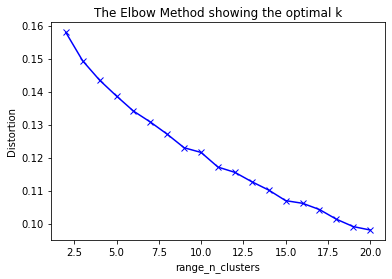

In [24]:
paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# k means determine k
distortions = []
range_n_clusters = range(2,21)
for k in range_n_clusters:
    kmeanModel = KMeans(n_clusters=k).fit(paris_grouped_clustering)
    distortions.append(sum(np.min(cdist(paris_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / paris_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(range_n_clusters, distortions, 'bx-')
plt.xlabel('range_n_clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

However on our dataset this method is limited, instead of showing a clear disruption, the curve is slowly decreasing. But with only 81 different categories, clustering Paris into more than 20 groups sounds not interesting.  
To tackle this issue, we use another method : the Silhouette Method.

##### Silhouette Method

For n_clusters = 2, silhouette score is 0.12070496893286234)
For n_clusters = 3, silhouette score is 0.12904539924373204)
For n_clusters = 4, silhouette score is 0.12412856132320642)
For n_clusters = 5, silhouette score is 0.12036579005409893)
For n_clusters = 6, silhouette score is 0.10296522999619798)
For n_clusters = 7, silhouette score is 0.10353505415170991)
For n_clusters = 8, silhouette score is 0.11412809083422029)
For n_clusters = 9, silhouette score is 0.10614219695416519)
For n_clusters = 10, silhouette score is 0.10236493944726169)
For n_clusters = 11, silhouette score is 0.09696620739057879)
For n_clusters = 12, silhouette score is 0.11546783434646583)


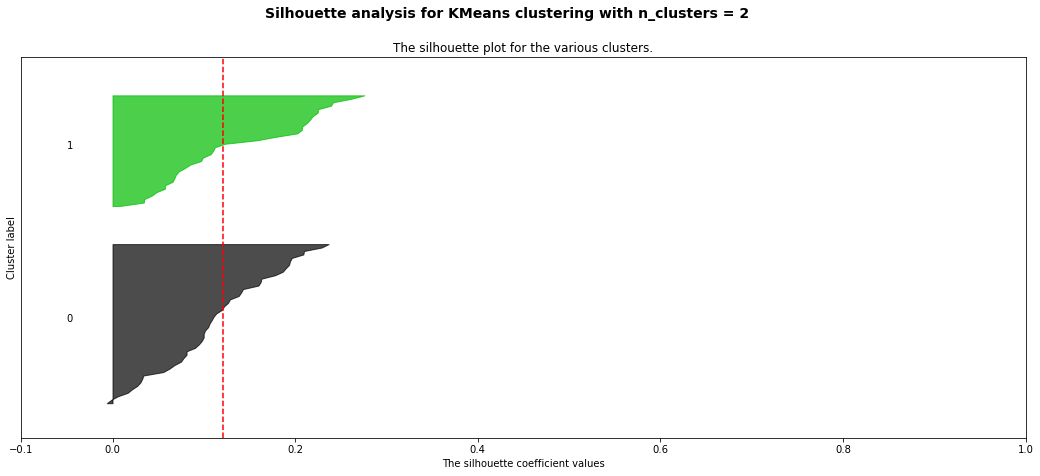

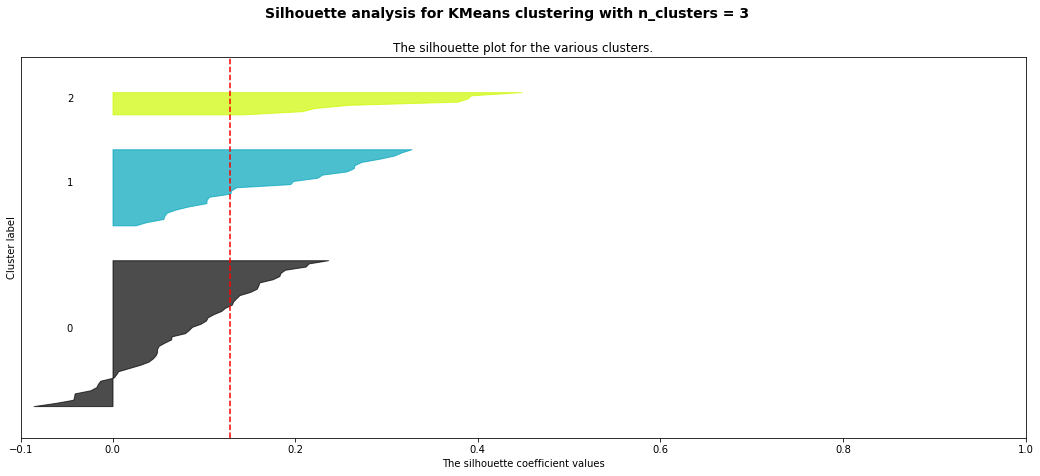

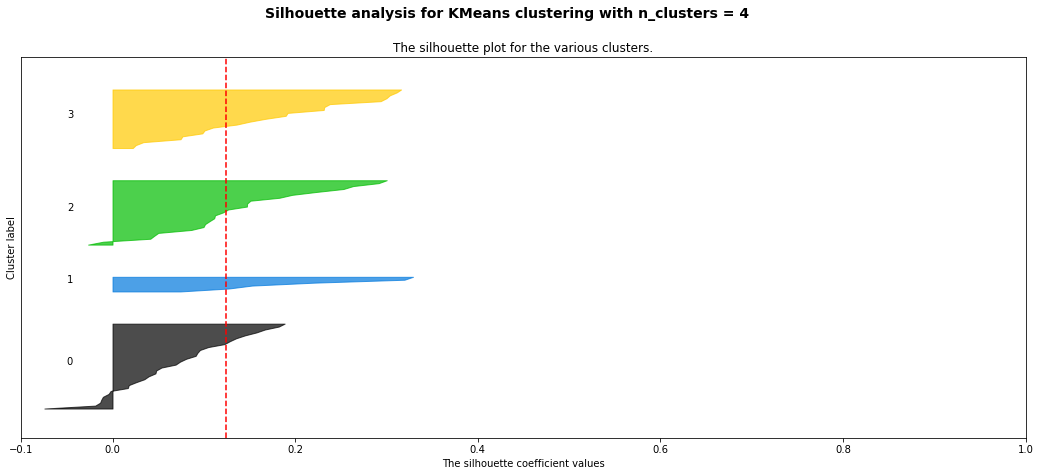

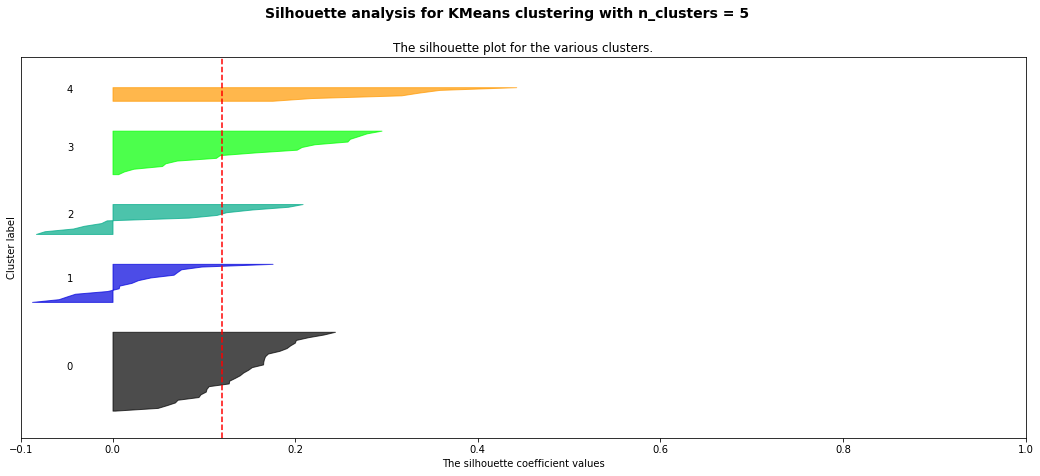

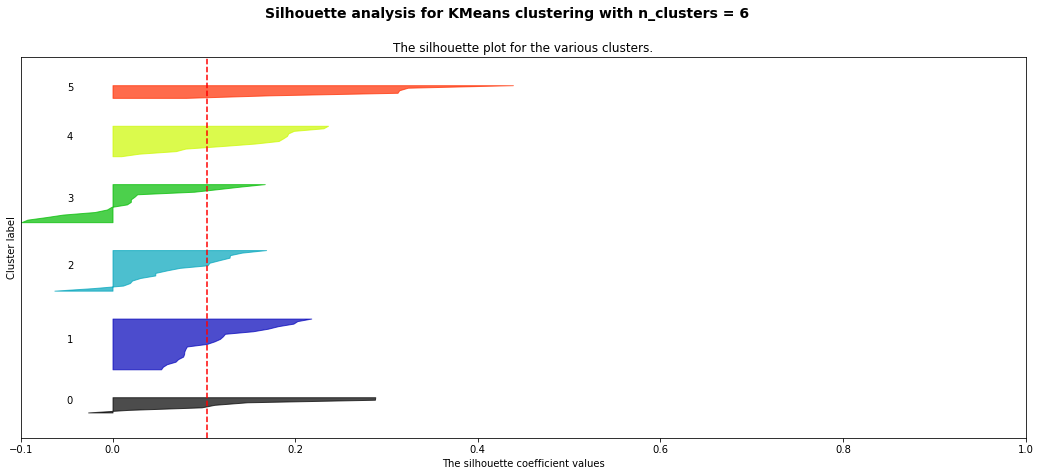

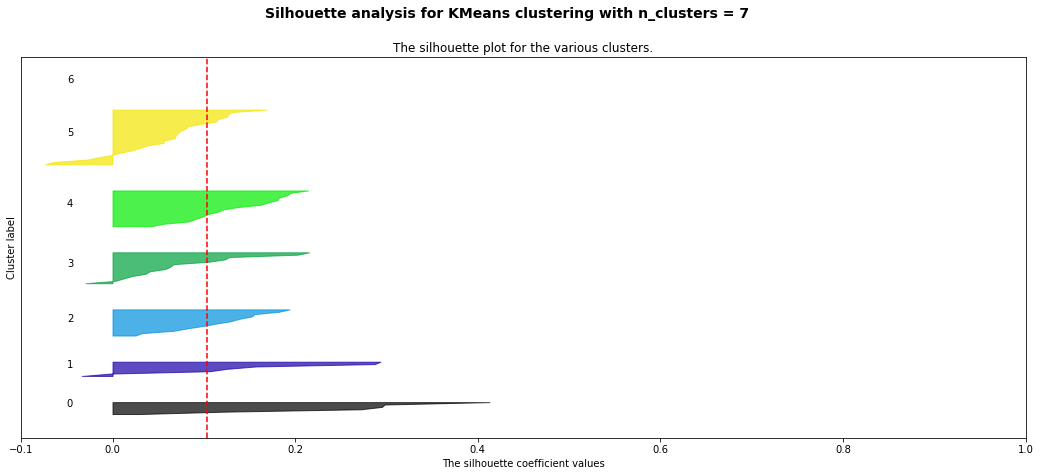

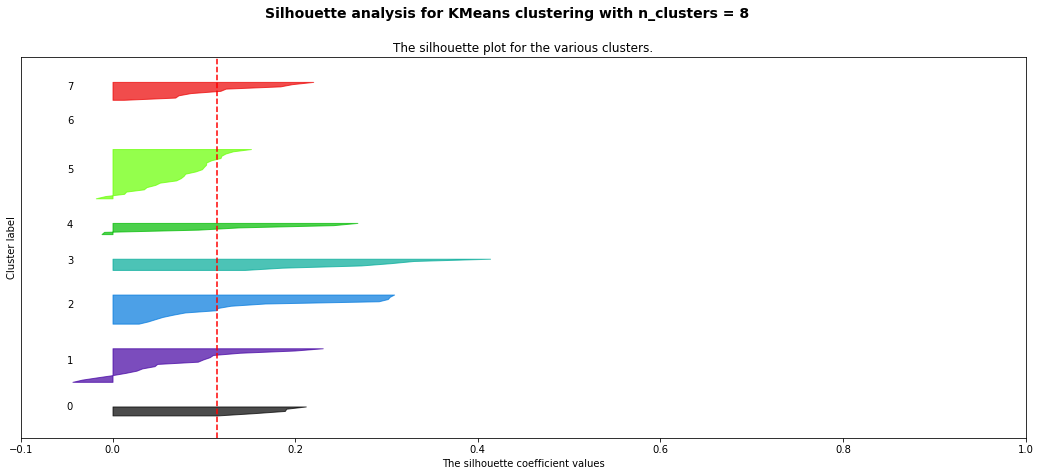

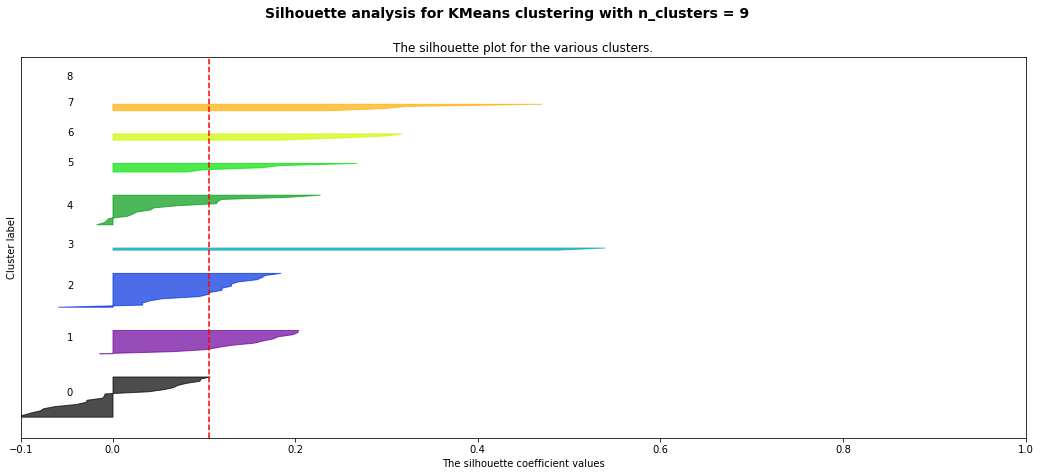

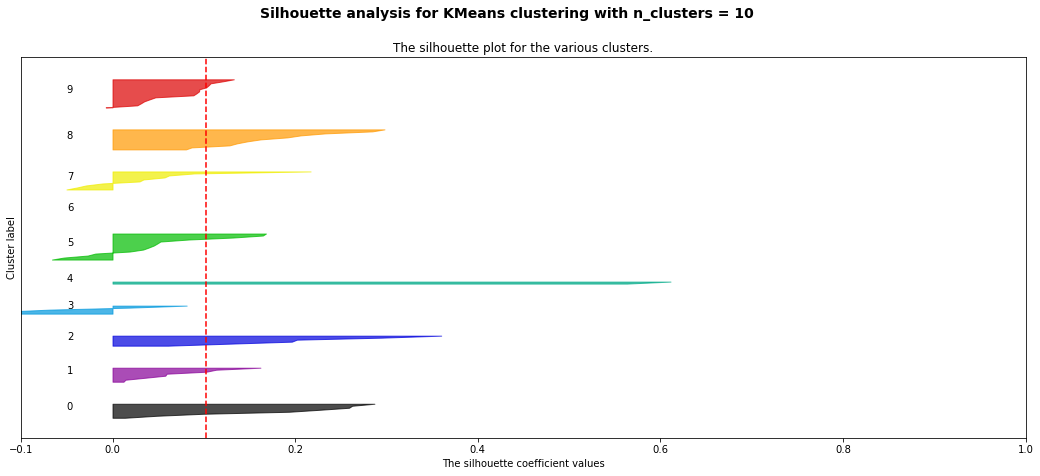

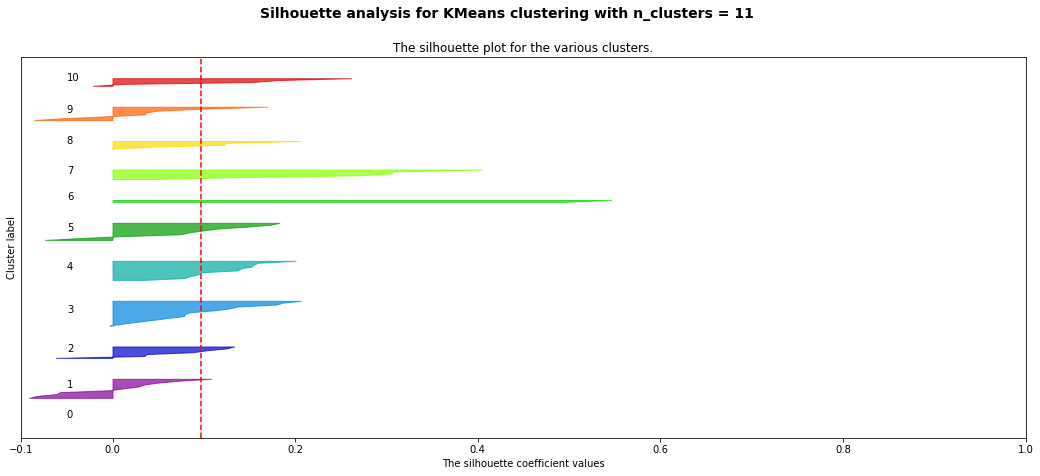

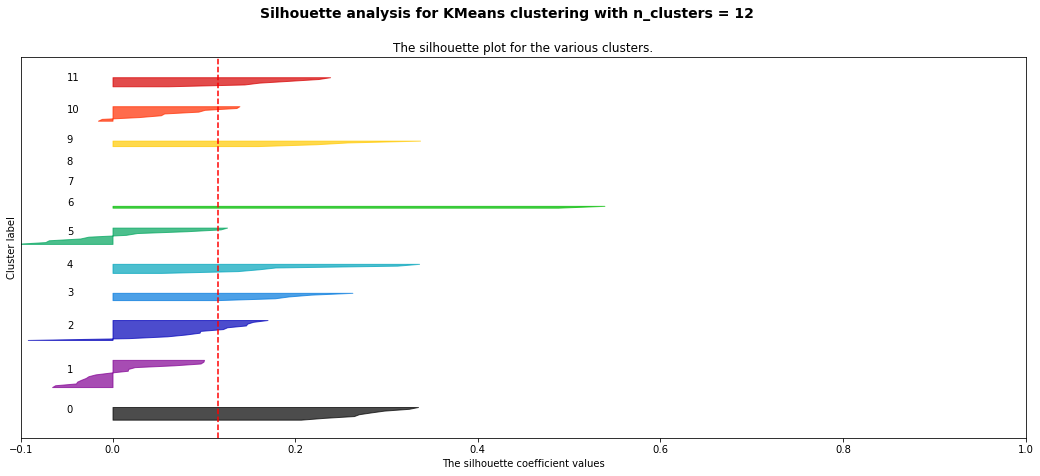

In [25]:
range_n_clusters = range(2,13)
silhouette_list = [np.nan, np.nan]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(paris_grouped_clustering) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters).fit(paris_grouped_clustering)
    cluster_labels = clusterer.fit_predict(paris_grouped_clustering)

    silhouette_avg = silhouette_score(paris_grouped_clustering, cluster_labels)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, silhouette_avg))
    silhouette_list.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(paris_grouped_clustering, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    plt.suptitle(("Silhouette analysis for KMeans clustering "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

To help choosing between all the previous graph, we can plot the average silhouette score for each K :

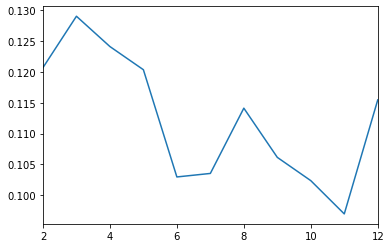

In [26]:
pd.Series(silhouette_list).reindex(range_n_clusters).plot()

Based on the silhouette method, we choose to use 8 clusters to segment Paris.  
This choice comes from a compromise between a great average silhouette score, not too many wrong placed item in each cluster and enough groups to illustrate our study.

<a id="ref42"></a>
### 4.2 k-means algorithm

We can now use the k-means algorithm to cluster our dataset into 8 groups :

In [27]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:] 

array([4, 1, 2, 1, 0, 4, 4, 7, 4, 7, 0, 0, 4, 1, 1, 7, 4, 2, 1, 4, 0, 1,
       0, 1, 3, 5, 6, 2, 1, 0, 7, 1, 2, 7, 0, 7, 0, 1, 5, 1, 1, 2, 4, 4,
       2, 1, 3, 4, 4, 4, 0, 0, 4, 1, 0, 1, 1, 4, 2, 2, 1, 1, 4, 4, 0, 3,
       1, 4, 4, 2, 0, 4, 7, 1, 0, 1, 0, 1, 4, 3], dtype=int32)

In [28]:
# add clustering labels
neigh_venues_kmean = pd.DataFrame(neighborhood_venues_sorted)
neigh_venues_kmean.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = df_neigh

# merge paris_grouped with df_neigh to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neigh_venues_kmean.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head()

,ID,Neighborhood,Borough,Latitude,Longitude,Min_Longitude,Max_Longitude,Min_Latitude,Max_Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,23,Notre-Dame-des-Champs,6,48.846428,2.327357,2.316572,2.336789,48.839653,48.852477,2,Italian Restaurant,Bakery,Brasserie,Japanese Restaurant,Creperie
1,55,Petit-Montrouge,14,48.826653,2.326437,2.314158,2.336089,48.818896,48.834976,4,Brasserie,Italian Restaurant,Japanese Restaurant,Bakery,Vietnamese Restaurant
2,74,Pont-de-Flandre,19,48.895556,2.384777,2.370165,2.398817,48.886618,48.902162,1,Brasserie,Japanese Restaurant,Asian Restaurant,Burger Joint,Pizza Place
3,62,Muette,16,48.863275,2.259936,2.229585,2.291954,48.850356,48.876355,2,Italian Restaurant,Bakery,Japanese Restaurant,Brasserie,Pizza Place
4,64,Chaillot,16,48.868434,2.291679,2.283351,2.301590,48.859909,48.877491,0,Italian Restaurant,Brasserie,Japanese Restaurant,Thai Restaurant,Lebanese Restaurant


<a id="ref43"></a>
### 4.3 Display the results on a map

In [29]:
# create map
map_clusters = folium.Map(location=[48.866667, 2.333333], zoom_start=11)

# Render the neighborhoods shapes
map_clusters.choropleth(
    geo_data = geo_paris,
    fill_color='Blue', 
    fill_opacity=0.35, 
    line_opacity=0.8,
    line_color='white'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id="ref44"></a>
### 4.4 Examine the proposed clusters

As our clusters are defined by the k-means algorithm, we now need to analyze these groups and try to understand what make them different to another.

##### Cluster 0

In [41]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(9, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Chaillot,0,Italian Restaurant,Brasserie,Japanese Restaurant,Thai Restaurant,Lebanese Restaurant
12,Auteuil,0,Italian Restaurant,Japanese Restaurant,Brasserie,Bakery,Middle Eastern Restaurant
13,Saint-Victor,0,Italian Restaurant,Japanese Restaurant,Bakery,Brasserie,Burger Joint
14,Madeleine,0,Italian Restaurant,Brasserie,Japanese Restaurant,Thai Restaurant,Asian Restaurant
16,Porte-Dauphine,0,Italian Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Pizza Place
20,Gros-Caillou,0,Italian Restaurant,Brasserie,Bakery,Japanese Restaurant,Pizza Place
28,Salpêtrière,0,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Bakery,Brasserie
29,Place-Vendôme,0,Japanese Restaurant,Italian Restaurant,Bakery,Brasserie,Tapas Restaurant
32,Javel,0,Italian Restaurant,Japanese Restaurant,Bakery,Brasserie,Persian Restaurant
38,Champs-Elysées,0,Italian Restaurant,Bakery,Japanese Restaurant,Steakhouse,Brasserie


With nearly only _Italian Restaurant_ as a 1st most common venue followed by _Japanese Restaurants_, this cluster is a mix between these two cuisine.  
We can also see some French specialties, such as Bakery and Brasserie, but in less important way.

##### Cluster 1

In [42]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(9, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Pont-de-Flandre,1,Brasserie,Japanese Restaurant,Asian Restaurant,Burger Joint,Pizza Place
7,Faubourg-Montmartre,1,Italian Restaurant,Thai Restaurant,Brasserie,Japanese Restaurant,Pizza Place
11,Grenelle,1,Italian Restaurant,Brasserie,Bakery,Pizza Place,Japanese Restaurant
23,Porte-Saint-Martin,1,Pizza Place,Italian Restaurant,Brasserie,Burger Joint,Indian Restaurant
24,Roquette,1,Brasserie,Japanese Restaurant,Italian Restaurant,Pizza Place,Vietnamese Restaurant
27,Folie-Méricourt,1,Brasserie,Italian Restaurant,Pizza Place,Vietnamese Restaurant,Bakery
36,Monnaie,1,Italian Restaurant,Brasserie,Japanese Restaurant,Pizza Place,Creperie
37,Odéon,1,Brasserie,Italian Restaurant,Japanese Restaurant,Bakery,New American Restaurant
42,Enfants-Rouges,1,Brasserie,Japanese Restaurant,Italian Restaurant,Burger Joint,Bakery
45,Saint-Ambroise,1,Brasserie,Italian Restaurant,Bakery,Pizza Place,Japanese Restaurant


Full of _Brasseries_ and some _Creperies_, this cluster stay French oriented cuisine even when keeping only few categories.  
Like others places, we can still find some Italian and Asian restaurants.

##### Cluster 2

In [170]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(9, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Notre-Dame-des-Champs,2,Italian Restaurant,Bakery,Brasserie,Japanese Restaurant,Creperie
3,Muette,2,Italian Restaurant,Bakery,Japanese Restaurant,Brasserie,Pizza Place
6,Invalides,2,Brasserie,Bakery,Italian Restaurant,Japanese Restaurant,Pizza Place
10,Ecole-Militaire,2,Italian Restaurant,Bakery,Brasserie,Spanish Restaurant,Japanese Restaurant
17,Grandes-Carrières,2,Italian Restaurant,Brasserie,Bakery,Pizza Place,Spanish Restaurant
21,Arsenal,2,Italian Restaurant,Bakery,Gastropub,Tapas Restaurant,Pizza Place
33,Rochechouart,2,Bakery,Italian Restaurant,Japanese Restaurant,Pizza Place,Burger Joint
54,Saint-Thomas-d'Aquin,2,Italian Restaurant,Bakery,Brasserie,Japanese Restaurant,Pizza Place
58,Quinze-Vingts,2,Italian Restaurant,Bakery,Pizza Place,Vietnamese Restaurant,Creperie


Back to the _Italian_ cuisine but followed by _Bakeries_.

##### Cluster 3

In [47]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(9, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Gaillon,3,Japanese Restaurant,Italian Restaurant,Korean Restaurant,Burger Joint,Asian Restaurant
41,Vivienne,3,Japanese Restaurant,Brasserie,Italian Restaurant,Bakery,Thai Restaurant
56,Saint-Germain-l'Auxerrois,3,Japanese Restaurant,Bakery,Italian Restaurant,Pizza Place,Brasserie
79,Palais-Royal,3,Japanese Restaurant,Italian Restaurant,Bakery,Brasserie,Korean Restaurant


This small cluster regroups the Japanese Restaurants areas.

In [60]:
num_top_venues = 5

list_neigh = ['Gaillon', 'Vivienne', 'Saint-Germain-l\'Auxerrois', 'Palais-Royal']

for neigh in list_neigh:
    print("----"+neigh+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Gaillon----
                 venue  freq
0  Japanese Restaurant  0.29
1   Italian Restaurant  0.14
2    Korean Restaurant  0.07
3         Burger Joint  0.07
4           Steakhouse  0.05


----Vivienne----
                 venue  freq
0  Japanese Restaurant  0.30
1            Brasserie  0.15
2   Italian Restaurant  0.12
3               Bakery  0.08
4      Thai Restaurant  0.05


----Saint-Germain-l'Auxerrois----
                 venue  freq
0  Japanese Restaurant  0.30
1               Bakery  0.12
2   Italian Restaurant  0.10
3          Pizza Place  0.08
4            Brasserie  0.06


----Palais-Royal----
                 venue  freq
0  Japanese Restaurant  0.39
1   Italian Restaurant  0.12
2               Bakery  0.11
3    Korean Restaurant  0.08
4            Brasserie  0.08




##### Cluster 4

In [172]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(9, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Petit-Montrouge,4,Brasserie,Italian Restaurant,Japanese Restaurant,Bakery,Vietnamese Restaurant
5,Epinettes,4,Japanese Restaurant,Brasserie,Italian Restaurant,Pizza Place,Bakery
9,Amérique,4,Japanese Restaurant,Bakery,Pizza Place,Brasserie,Fast Food Restaurant
15,Saint-Fargeau,4,Bakery,Japanese Restaurant,Brasserie,Italian Restaurant,Pizza Place
18,Saint-Merri,4,Bakery,Brasserie,Burger Joint,Hot Dog Joint,Portuguese Restaurant
19,Notre-Dame,4,Japanese Restaurant,Brasserie,Bakery,Thai Restaurant,Creperie
25,Picpus,4,Italian Restaurant,Japanese Restaurant,Brasserie,Bakery,Thai Restaurant
26,Plaisance,4,Japanese Restaurant,Bakery,Brasserie,Pizza Place,Indian Restaurant
31,Charonne,4,Japanese Restaurant,Pizza Place,Brasserie,Italian Restaurant,Fast Food Restaurant
34,Bercy,4,Japanese Restaurant,Bakery,Italian Restaurant,Brasserie,Burger Joint


Contrary to the cluster 3, dedicated to Japanese Cuisine, this cluster mix the Japanese with the French bakeries and brasseries.

##### Cluster 5

In [61]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[1] + list(range(9, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
39,Maison-Blanche,5,Vietnamese Restaurant,Chinese Restaurant,Asian Restaurant,Thai Restaurant,Bakery
73,Gare,5,Vietnamese Restaurant,Chinese Restaurant,Asian Restaurant,Thai Restaurant,Italian Restaurant


With only two neighborhoods, this cluster is an Asian place.

##### Cluster 6

In [174]:
paris_merged.loc[paris_merged['Cluster Labels'] == 6, paris_merged.columns[[1] + list(range(9, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
75,Goutte-d'Or,6,Fast Food Restaurant,Pizza Place,Brasserie,Indian Restaurant,Mexican Restaurant


In [63]:
print("----"+'Goutte-d\'Or'+"----")
temp = paris_grouped[paris_grouped['Neighborhood'] == 'Goutte-d\'Or'].T.reset_index()
temp.columns = ['venue','freq']
temp = temp.iloc[1:]
temp['freq'] = temp['freq'].astype(float)
temp = temp.round({'freq': 2})
print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
print('\n')

----Goutte-d'Or----
                  venue  freq
0  Fast Food Restaurant  0.29
1           Pizza Place  0.21
2             Brasserie  0.21
3                Bakery  0.07
4   Japanese Restaurant  0.07




Placed alone in the Cluster 6, the neighborhood _Goutte-d'Or_ is a place to eat on the go with Fast-Food and Pizza. 

##### Cluster 7

In [175]:
paris_merged.loc[paris_merged['Cluster Labels'] == 7, paris_merged.columns[[1] + list(range(9, paris_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,Jardin-des-Plantes,7,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Bakery,Greek Restaurant
30,Combat,7,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Bakery
35,Halles,7,Bakery,Pizza Place,Italian Restaurant,Chinese Restaurant,Brasserie
52,La Chapelle,7,Bakery,Indian Restaurant,Asian Restaurant,Thai Restaurant,Brasserie
66,Sainte-Avoie,7,Chinese Restaurant,Bakery,Italian Restaurant,Thai Restaurant,Burger Joint
68,Belleville,7,Chinese Restaurant,Bakery,Vietnamese Restaurant,Pizza Place,Thai Restaurant
72,Bonne-Nouvelle,7,Bakery,Pizza Place,Turkish Restaurant,Thai Restaurant,Italian Restaurant


In [64]:
num_top_venues = 5

list_neigh = ['Jardin-des-Plantes', 'Combat', 'Halles', 'La Chapelle', 'Sainte-Avoie']

for neigh in list_neigh:
    print("----"+neigh+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Jardin-des-Plantes----
                 venue  freq
0               Bakery  0.09
1   Chinese Restaurant  0.09
2   Italian Restaurant  0.09
3  Japanese Restaurant  0.09
4     Greek Restaurant  0.08


----Combat----
                   venue  freq
0     Chinese Restaurant  0.19
1     Italian Restaurant  0.10
2    Japanese Restaurant  0.09
3  Vietnamese Restaurant  0.07
4            Pizza Place  0.07


----Halles----
                venue  freq
0         Pizza Place  0.20
1              Bakery  0.20
2  Italian Restaurant  0.10
3  Chinese Restaurant  0.10
4           Brasserie  0.08


----La Chapelle----
                venue  freq
0              Bakery  0.14
1   Indian Restaurant  0.10
2  Chinese Restaurant  0.10
3     Thai Restaurant  0.10
4    Asian Restaurant  0.10


----Sainte-Avoie----
                venue  freq
0  Chinese Restaurant  0.18
1              Bakery  0.14
2     Thai Restaurant  0.09
3        Burger Joint  0.09
4  Italian Restaurant  0.09




Based on the frequency of venues in these Neighborhoods, a distinction is more difficult for the cluster 7. In fact, if a common point is with at least 10% of these venues are Chinese restaurant, each neighborhood has their own specificities.  
This cluster need to be considered as a mix cuisine place.

##### Sum-up



Cluster | Main Region of Cuisine
--- | ---
0 | Italian - Japanese
1 | French
2 | Italian and Bakeries
3 | Japanese
4 | Japanese - French (Brasseries and Bakeries)
5 | Asian
6 | Fast-Food
7 | Mix

<a id="ref5"></a>
## 5. Conclusion

In this study, we clustered the city of Paris into eight different groups, based on the main cuisine of their restaurants.  
During the data wandering, several choices were made to simplify the study and prevent any bias, namely falsely representing French cuisine everywhere as its number of venues is overwhelming.  
The final results could be more refined using another location API, more dedicated to Restaurant with a better classification of cuisine subcategories. In addition, due to how we retrieved venues, our dataset is presenting redundant data, as some of the neighborhoods are collapsing into each other when calling the Foursquare API using a square method and not the official Parisian boroughs boundaries.  

Another interesting point to add in this study would be leveraging economy data such as the price of renting or incomes of its inhabitants in each neighborhood in order to see if a correlation could be made between the cuisine provided and the community living there.